# Concise Overview of OpenPNM

In [1]:
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib.pyplot as plt
op.Workspace().settings['loglevel'] = 50

## Creating a network


OpenPNM includes several network "generators", including the traditional cubic lattice that will be used here. Refer to **Tutorials > Network** for more information.

For this introduction we'll start by just using a standard cubic network:

In [2]:
Lx, Ly, Lz = 4, 6, 8
spacing = 1e-4
pn = op.network.Cubic(shape=[Lx, Ly, Lz], spacing=spacing)

## Quick visualization of topology

OpenPNM support Paraview for very detailed visualization, but it's possible to get a quick view of a network for inspection within python.  

|Links to Related Notebooks|
|:-------------------------|
| [A detailed illustration of OpenPNM's plotting functionality](quick_plotting_networks.ipynb)| 
| FIXME: Export to Paraview is the preferred way to visualize a network|


AttributeError: module 'openpnm.topotools' has no attribute 'plot_coordinates'

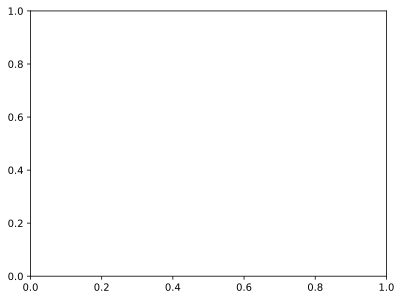

In [3]:
fig, ax = plt.subplots()
op.topotools.plot_coordinates(network=pn, c='r', s=50, ax=ax)
op.topotools.plot_connections(network=pn, ax=ax)

## Printing objects

One of the most useful development or debugging tools is to ``print`` the network, so see a list of its properties:

In [4]:
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x7fdf50633e50>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                     192 / 192
  2  throat.conns                                                    472 / 472
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.back                                                              32
  2  pore.bottom                                                            24
  3  pore.front                                                             32
  4

## Adding geometrical properties

The network only stores topological information.  Geometry objects are used to store information like pore and throat sizes.  Each simulation should have a geometry object associated with it.  We can create an empty geometry and add properties to it later:

In [5]:
geo = op.geometry.GenericGeometry(network=pn, pores=pn.Ps, throats=pn.Ts)

AttributeError: module 'openpnm' has no attribute 'geometry'

## Adding pore-scale models

Pore-scale models are one of the most useful aspects of OpenPNM.

|Links to Related Notebooks|
|:-------------------------|
| [In-depth discussion and illustration of pore-scale models](../tutorials/physics/pore_scale_models.ipynb)|

Below we'll add a few to ``geo``.  OpenPNM includes a library of pre-written models to choose from.  First assign a random seed to each pore

In [6]:
geo.add_model(propname='pore.seed',
              model=op.models.geometry.pore_size.random,
              seed=0)

NameError: name 'geo' is not defined

Next use the seed to find pore sizes from the cumulative pore size distribution. This process is described in detail [here](../tutorials/geometry/adjusting_pore_size_distributions.ipynb).

In [7]:
geo.add_model(propname='pore.diameter',
              model=op.models.geometry.pore_size.weibull,
              scale=0.5e-4, shape=0.8, loc=1e-6)

NameError: name 'geo' is not defined

We can also add models for pore volume, as well as throat diameter, length, and volume:

In [8]:
geo.add_model(propname='pore.volume',
              model=op.models.geometry.pore_volume.sphere)
geo.add_model(propname='throat.diameter',
              model=op.models.geometry.throat_size.from_neighbor_pores,
              mode='min')
geo.add_model(propname='throat.length',
              model=op.models.geometry.throat_length.classic)
geo.add_model(propname='throat.volume',
              model=op.models.geometry.throat_volume.cylinder)
geo.add_model(propname='throat.hydraulic_size_factors',
              model=op.models.geometry.hydraulic_size_factors.spheres_and_cylinders)

NameError: name 'geo' is not defined

## Adjusting pore-scale models

All the models that have been added to an object are stored in the ``models`` attribute, under the same key as the property they calculate.  The parameters of each model are also stored and can be adjusted

|Links to Related Notebooks|
|:-------------------------|
| [Adjusting the pore size distribution](../tutorials/geometry/adjusting_pore_size_distributions.ipynb)| 

In [9]:
print(geo.models)

NameError: name 'geo' is not defined

In [10]:
geo.models['pore.diameter']['shape'] = 1.5

NameError: name 'geo' is not defined

This change is not reflected in the 'pore.diameter' values until ``regenerate_models`` is run.  This process also automatically updates all the values that depend on it like 'pore.volume'.

In [11]:
geo.regenerate_models()

NameError: name 'geo' is not defined

## Inspecting histograms of properties

Ideally, [matplotlib](https://realpython.com/python-matplotlib-guide/) should be used to make nice plots of pore size histograms and such, but each OpenPNM object has the ability to plot histograms for quick inspections:

In [12]:
geo.show_hist(['pore.diameter', 'throat.diameter', 'throat.length'])

NameError: name 'geo' is not defined

## Creating phases with thermophysical properties

It's possible to create a blank phase with no properties or pore-scale models. 

In [13]:
water = op.phases.GenericPhase(network=pn)
print(water)

AttributeError: module 'openpnm' has no attribute 'phases'

## Adding static data

The phase objec created above is empty of all physical properties.  We could add pore-scale models if desired, as done for ``geo``, but we can also add a static value directly.

In [14]:
water['pore.viscosity'] = 0.001

NameError: name 'water' is not defined

These are several important features evidient in the above line. 

|Links to Related Notebooks|
|:-------------------------|
|[Overview of data storage in OpenPNM](../reference/data_management/data_and_topology_storage.ipynb)|

## Using pre-defined classes that include pore-scale models

OpenPNM includes a small selection of pre-defined phases which include common pore-scale model and preset parameters for describing their properties.

In [15]:
hg = op.phases.Mercury(network=pn)
print(hg)

AttributeError: module 'openpnm' has no attribute 'phases'

## Defining physics

The last step of the 'setup' of an OpenPNM simulation involves defining which pore-scale physics to use in algorithms.  For capillary pressure curves, for instance, we need to calcuate the entry pressure of each throat.  This is often doen using the Washburn equation.

These pore-scale models are applied to a physics object.  

In [16]:
phys = op.physics.GenericPhysics(network=pn, phase=hg, geometry=geo)

AttributeError: module 'openpnm' has no attribute 'physics'

In [17]:
phys.add_model(propname='throat.entry_pressure',
               model=op.models.physics.capillary_pressure.washburn)

NameError: name 'phys' is not defined

## Overview of the simulation setup


Physics objects require know to which phase *and* geometry they belong.  This is because physics models always combine both geometrical and thermophysical information. In other words, when calculating a physics model, data must be pulled from both an associated phase (e.g. surface tension) and the corresponding geometry (e.g. pore size). 

This relationship is summarized by 'the grid'.  This shows the relationship between various objects, with physics object laying at the intersection of a phase and a geometry.  


|Links to Related Notebooks|
|:-------------------------|
|**The role of the Workspace and Projects is explained further** [here](../reference/workspace/overview_of_workspace_and_projects.ipynb)|
|**The 'grid' is particularly useful when several subdomains have been defined as demonstrated** [here](../reference/workspace/overview_of_subdomains.ipynb)|


In [18]:
print(pn.project.grid)

AttributeError: 'Project' object has no attribute 'grid'

## Objects can have names

The above table may be unhelpful if there are a lot of objects in the project.  This can be remedied by giving them unique names.

In [19]:
hg.name = 'mercury'
water.name = 'water'

NameError: name 'hg' is not defined

In [20]:
print(pn.project.grid)

AttributeError: 'Project' object has no attribute 'grid'

## Running a simulation

OpenPNM includes a large assortment of pre-written algorithms for simulating various physical processes. 


## Performing a porosimetry simulation

It is common to simulate the capillary pressure curve of a material since this is usually measured experimentally so a comparison can be made.  

In [21]:
mip = op.algorithms.Porosimetry(network=pn, phase=hg)
mip.set_inlets(pores=pn.pores('left'))
mip.run()

AttributeError: module 'openpnm.algorithms' has no attribute 'Porosimetry'

In [22]:
fig = mip.plot_intrusion_curve()

NameError: name 'mip' is not defined

## Using labels to find pore indices

The above simulation used ``pn.pores('left')`` during the call to ``set_inlets``.  All OpenPNM objects have a ``pores`` and a ``throats`` method that retrieves pore/throat indices if a certain label has been applied to them.

|Links to Related Notebooks|
|:-------------------------|
|**Labels are discussed at length** [here](../reference/data_management/using_and_creating_labels.ipynb)|

Many common labels are added to networks during creation, usually indicating faces like 'left' and 'right', which are useful for applying boundary conditions.


## Running a fluid flow simulation

Another type of simulation is to determine permeabilit of a network.  This is done using the StokesFlow algorithm.

Before proceeding though, we must remember that we did not define a pore-scale hydraulic conductance model.  It is possible to assign a physics model to a phase (and geometry models to the network), but you should really know what your doing.  This is illustrated below:

In [23]:
water.add_model(propname='throat.hydraulic_conductance',
                model=op.models.physics.hydraulic_conductance.hagen_poiseuille)

NameError: name 'water' is not defined

In [24]:
sf = op.algorithms.StokesFlow(network=pn, phase=water)
sf.set_value_BC(pores=pn.pores('left'), values=1)
sf.set_value_BC(pores=pn.pores('right'), values=0)
sf.run()

NameError: name 'water' is not defined

## Altering the settings of a simulation

All OpenPNM objects have a ``settings`` attribute, which is dictionary containing a variety of information about how the algorithm is run.

In [25]:
print(sf.settings)

NameError: name 'sf' is not defined

## Estimating permeability coefficient of a network

Now that the fluid flow simulation has been run, its possible to determine the network's permeability by applying Darcy's law.

$$ Q = \frac{K A}{\mu L}\Delta P $$

We know $A$ and $L$ from the network dimension, and $\mu$ was specified as $ 0.001 Pa\cdot s$ since we're using ``water`` as the phase.  We also applied the $\Delta P$ as (1-0).  Therefore finding $K$ can be done algebraically once $Q$ is known.  

Transport algorithms possess a ``rate`` method that calculates the rate through a set of pores.  Find the rate through one of the boundary faces can be done as:

In [26]:
Q = sf.rate(pores=pn.pores('left'))

NameError: name 'sf' is not defined

We also know:

In [27]:
A = Lx*Ly*spacing**2
L = Lz*spacing
mu = 0.001
dP = 1

Therefore, the permeability coefficient for this network is:

In [28]:
K = Q*mu*L/A/dP
print(K)

NameError: name 'Q' is not defined

## Returning results to the phase object

Upon running the fluid flow simulation above, the pressure in each pore is solved for.  These results are not automatically pushed back to the associated phase, and the user must explicity do so as follows:

In [29]:
water.update(sf.results())

NameError: name 'water' is not defined

## Outputting or saving simualtion results

Once the simulation is complete it can be either output to Paraview as described here (FIXME) or saved to one of several file formats for post-processing.
